<a href="https://colab.research.google.com/github/Mattobad/AWS-Textract/blob/master/End_to_End_Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# process to unzip the file 
#!unzip "drive/My Drive/Data/rsna-pneumonia-detection-challenge.zip" -d "drive/My Drive/Data/pneumonia-data"

## End to End image classification for Pneumonia Detection using X-ray Images

In this notebook, we're going to implement end to end Binary image classification to detect pneumonia in the x-ray images using Tensorflow 2.0 and Tensorflow Hub

###### 1. Problem
To detect the traces of pneumonia in the x-ray images.

###### 2. Data
The data was taken from Kaggle's Pneumonia detection challenge. [Link to the data](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data)

###### 3. Evaluation
Right something about the evaluation metric used


**Note:** write more about the project for your audience

##### 1. Making your workspace ready.

In [ ]:
# Import TF 2.x
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)

print("TF HUB version:", hub.__version__)
#Check for GPU availability
print("GPU","available (YESS!!)" if tf.config.list_physical_devices("GPU") else "GPU not available")

TF version: 2.2.0
TF HUB version: 0.8.0
GPU GPU not available


In [2]:
# install the pydicom module as required for patient data
!pip install pydicom pypng

     |████████████████████████████████| 35.5MB 1.4MB/s 
     |████████████████████████████████| 655kB 48.7MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp36-none-any.whl size=67161 sha256=82a7ab4394850957b4519f7bfcaf3c3df41fa115b9a1d4e400cf9cff0edc7666
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom 

labels_csv = pd.read_csv('drive/My Drive/Data/pneumonia-data/stage_2_train_labels.csv')
print(labels_csv.describe())
labels_csv.head(2)

                 x            y        width       height        Target
count  9555.000000  9555.000000  9555.000000  9555.000000  30227.000000
mean    394.047724   366.839560   218.471376   329.269702      0.316108
std     204.574172   148.940488    59.289475   157.750755      0.464963
min       2.000000     2.000000    40.000000    45.000000      0.000000
25%     207.000000   249.000000   177.000000   203.000000      0.000000
50%     324.000000   365.000000   217.000000   298.000000      0.000000
75%     594.000000   478.500000   259.000000   438.000000      1.000000
max     835.000000   881.000000   528.000000   942.000000      1.000000


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


In [ ]:
labels_csv[labels_csv['Target'] == 1][:1] 

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


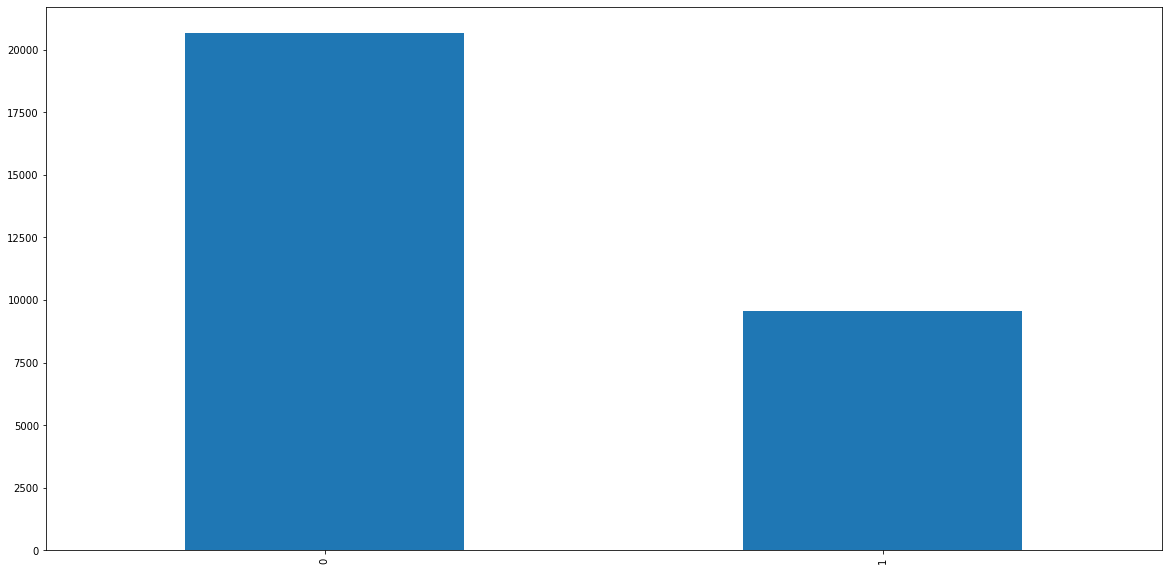

In [ ]:
labels_csv.Target.value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

So,there are 20672 record of patient without pneumonia and 9555 record of patient with pneumonia

##### 2. Understanding the DICOM(Digital Imaging and Communications in Medicine) files

Dicom files consists of all the metadata related to patient and the images. Python library pydicom is used here for exploring the dicom files.

In [6]:
# to read the first patient ID
patientId = labels_csv['patientId'][0]
dcm_file = 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)
#0004cfab-14fd-4e49-80ba-63a80b6bddd6

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [9]:
# function to display images
import pylab
def display_image(f):
  # dcm_data = pydicom.read_file(f)
  # im = dcm_data.pixel_array
  im = image_pixel(f)
  pylab.imshow(im, cmap=pylab.cm.gist_gray)
  pylab.axis('off')


# function to return image pixel
def image_pixel(file_name):
  dcm_data = pydicom.read_file(file_name)
  img_pixel = dcm_data.pixel_array
  return img_pixel

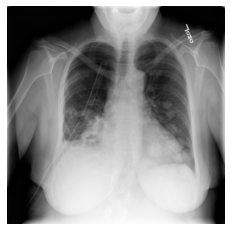

In [11]:
display_image(dcm_file)

In [ ]:
# create pathnames from dicom files
filenames = ['drive/My Drive/Data/pneumonia-data/stage_2_train_images/'+fname+'.dcm' for fname in labels_csv['patientId']]
print(len(filenames))
#check the first 10
filenames[:10]


30227


['drive/My Drive/Data/pneumonia-data/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00569f44-917d-4c86-a842-81832af98c30.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2

In [14]:
import os

path_to_test = "drive/My Drive/Data/pneumonia-data/stage_2_train_images/"
# test for file path to get the file name from the directory
files_with_id = [f for f in os.listdir(path_to_test) if f.endswith('.dcm')]
files_with_id[:2]

['fbea2dbf-3828-4b0b-a8cf-e1a1e513851b.dcm',
 'fc3759df-79a4-41f1-a461-a2d12f09f489.dcm']

[[255 203 114 ...   9   9   9]
 [233 160  96 ...  12  12  12]
 [180 105  75 ...  12  12  12]
 ...
 [160 167 158 ... 103 104 105]
 [179 166 161 ... 106 104 102]
 [204 170 166 ... 110 110 109]]


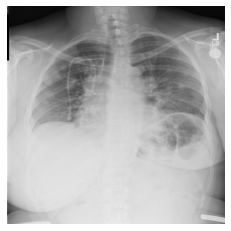

In [ ]:
# testing if the display function for image works
image = image_pixel(filenames[500])
print(image)
display_image(filenames[500])

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('drive/My Drive/Data/pneumonia-data/stage_2_train_images/')) == len(filenames):
  print('Filenames match the actual file length!!')
else:
  print('Filenames doesn\'t match the acutal file length')

print(len(os.listdir('drive/My Drive/Data/pneumonia-data/stage_2_train_images/')),len(filenames))



Filenames doesn't match the acutal file length
26684 30227


In [ ]:
print(len(labels_csv))
# number of unique patientId
print("Number of unique patient {}".format(len(np.unique(labels_csv['patientId']))))

30227
Number of unique patient 26684


Number of images doesn't match the number of files of patientID which means all the dicom files of the patient is not in the dataset. There are 26684 train dicom files and 3000 test dicom files which doesn't sum up to 30227(total was 29684 combining both train and test). But while looking for unique patientId found there were only 26684 unique patient. Some patient have more than one records.

###### Section for EDA(Exploratory Data Analysis)

In this particular section, we're going to extract the metadata of the patient like Patient Sex, Age and other useful resources to analysis the data and get to know who are mainly affected by pneumonia. Final step is to extract the pixel values, convert them to image format to get ready to feed into Neural Network. 


[link for the function taken for the following code](https://colab.research.google.com/github/ajsanjoaquin/COVID-19-Scanner/blob/master/covidtesting_notebook(Resnet34).ipynb#scrollTo=RxNnBs9pUC2-)

In [ ]:
# function to get the metadata and convert pixel to image format(png)
import os
import pydicom
from png import Writer


def dicom_to_png_metadata(source_path,dist_path,file_name):
  """
  Function returns metadata(Patient sex, age) and additionally 
  converts the pixel into image format and to folder 

  Args:
    source_path: files source directory
    attribute: metadata in dicom file of the patient
  
  Returns:
    metadata related to patient
  """
  ds = pydicom.dcmread(source_path+'/'+file_name+'.dcm')

  # list to carry patient
  patient_info = []

  # for image pixel to image format
  shape = ds.pixel_array.shape

  file_name = ds['Patient ID']
  # Convert to float to avoid overflow or underflow losses
  image_2d = df.pixel_array.astype(float32)

  # Rescaling grey scale between 0-255
  image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

  # convert to uint
  image_2d_scaled = np.uint8(image_2d_scaled)

  # Write the PNG file
  with open(os.path.join(dist_path,file_name+'.png'),'wb') as png_file:
    w = png.Writer(shape[1],shape[0],greyscale=True)
    w.write(png_file,image_2d_scaled)

  # try:
  #   attribute_value = getattr(ds,attribute)
  #   return attribute_value
  # except: return np.NaN
  try:
    patient_info.extend(ds["Patient's Age"],ds["Patient's Sex"])
    return patient_info
  except: 
    return 



#attribute list
#attributes = ['Patient_sex','Patient_age']

#Q. code to test the conversion function and save the user metadata into csv file
 # 1. create a dataFrame with patient id using files_with_id list
 # 2. call the conversion function (dicom_to_png_metadata) and store the
 # return list into file(loop through all the files using apply method)
 # 3. store the result list into the dataFrame


#Q. work with the png file similarly to the pneumonia detection from images..
# 1. try with LxNEt, AlexNet, RXnet architecture
# 2. try working with transfer learning

In [ ]:
# attribute list
#attributes = ['Patient_sex','Patient_age']

# code to test the conversion function and save the user metadata into csv file
 # 1. create a dataFrame with patient id using files_with_id list
 # 2. call the conversion function (dicom_to_png_metadata) and store the
 # return list into file(loop through all the files using apply method)
 # 3. store the result list into the dataFrame


# work with the png file similarly to the pneumonia detection from images..
# 1. try with LxNEt, AlexNet, RXnet architecture
# 2. try working with transfer learning

##### 3. Turning images into Tensor
Here we import standard libraries to convert the images to tensor, for making data ready to be feed into the Neural Network.

In [ ]:
# As it is binary classification so, no need to convert the labels(targets) in numeric
labels = labels_csv['Target']
labels

0        0
1        0
2        0
3        0
4        1
        ..
30222    1
30223    0
30224    0
30225    1
30226    1
Name: Target, Length: 30227, dtype: int64

In [ ]:
# See if the number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Matches")
else:
  print("Numbers doesn't matches")

Matches


In [ ]:
unique_labels = np.unique(labels)
unique_labels

array([0, 1])

###### Creating X and y 
Converting the images pixel into tensor in this section.

In [ ]:
# create X & y
X =[]
for f in filenames[:1000]:
  img = image_pixel(f)
  X.append(img)

y = labels[:1000]

In [ ]:

# removing extra dimension
X_temp = np.squeeze(X)
X_temp.shape

(1000, 1024, 1024)

In [ ]:
type(X_temp)

numpy.ndarray

In [ ]:
print(y.value_counts())
print(X_temp.shape)

0    572
1    428
Name: Target, dtype: int64
(1000, 1024, 1024)


In [ ]:
X_temp[:1]

array([[[144, 128, 114, ..., 176, 184, 117],
        [125, 109,  95, ..., 171, 178, 111],
        [104,  89,  75, ..., 166, 175, 108],
        ...,
        [ 16,  14,  11, ...,  19,  15,   3],
        [ 18,  16,  12, ...,  21,  17,   5],
        [ 19,  17,  13, ...,  23,  19,   6]]], dtype=uint8)

In [ ]:
# reshpae and normalize the image
X_temp = X_temp.reshape((1000,1024,1024,1))
# normalize the image pixel
X_temp = X_temp.astype('float32')/255.0

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider",min:1000,max:10000,step:1000}

In [ ]:
# let'split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train,X_val,y_train,y_val = train_test_split(X_temp[:NUM_IMAGES],
                                               y[:NUM_IMAGES],
                                               test_size=0.2,
                                               random_state=42)

len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [ ]:
X_train.shape

(800, 1024, 1024, 1)

##### Building model

In [ ]:
from keras import layers
from keras import models

# small convnet
model = models.Sequential()
#Conv2D(output_depth, (window_height, window_width))
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(1024,1024,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1022, 1022, 32)    320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 511, 511, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 509, 509, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 254, 254, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4064256)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.fit(X_train,y_train,epochs=5,batch_size=64)

# evalute the model
test_loss,test_acc = model.evaluate(X_val,y_val)
test_acc

Epoch 1/5
